# **Rede Neural Convolucional CNN - Classificação imagens raio-x Pneumonia**

# Part 1 - Business Problem

**Context**

Lung diseases such as **pneumonia** continue to be a leading cause of illness and death globally. Timely and accurate diagnosis is critical to ensuring proper treatment and improving clinical outcomes. Chest X-ray imaging is one of the most commonly used diagnostic tools, yet its interpretation can be time-consuming and subject to human error and inter-observer variability among radiologists.

**About the Dataset**

This project utilizes an adapted version of Paul Mooney’s **Chest X-Ray Images (Pneumonia)** dataset, which has been restructured to ensure a more balanced distribution between training, validation, and testing subsets.

| Dataset Split | Total Images | Normal Cases | Pneumonia Cases |
| ------------- | ------------ | ------------ | --------------- |
| Training      | 4,192        | 1,082        | 3,110           |
| Validation    | 1,040        | 267          | 773             |
| Testing       | 624          | 234          | 390             |
| **Total**     | **5,856**    | **1,583**    | **4,273**       |

**Business Objective**

The goal of this project is to **build a robust deep learning solution** that can automatically classify chest X-ray images as either:

* **Normal** (healthy lungs)
* **Pneumonia** (lung opacity detected)

The AI model will serve as a **diagnostic support tool** for medical professionals, with potential applications in:

* Reducing diagnostic workload
* Assisting in early detection of pneumonia
* Enabling remote triage and screening in underserved regions

**Technical Approach**

To address this challenge, we implemented and compared multiple deep learning architectures:

* **Sequential Convolutional Neural Network (CNN)**: A custom baseline model built from scratch
* **VGG16**: A well-established deep CNN architecture using 3×3 convolutions and trained on **ImageNet**
* **ResNet50**: A residual network that uses skip connections to enable very deep architectures
* **InceptionV3**: An efficient architecture that uses parallel filters and factorized convolutions

All pretrained models leveraged **ImageNet weights** and were fine-tuned for binary classification using **transfer learning** techniques.

**Machine Learning Formulation**

* **Problem Type**: Binary Image Classification
* **Input**: Chest X-ray image (resized to 224×224 or 299×299 RGB)
* **Output**: Predicted label — *Normal* or *Pneumonia*
* **Evaluation Metrics**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix, AUC

**Potential Impact**

The successful deployment of such a system can:

* Enhance diagnostic speed and consistency.
  
* Assist in early intervention and patient prioritization.

  
* Extend diagnostic capabilities to low-resource environments.

  
* Support overwhelmed medical systems during pandemics or flu seasons.

# **Part 2 - API Kaggle**

In [1]:
#!pip install -q kaggle

In [2]:
#import zipfile
#from google.colab import files
#files.upload()

In [3]:
#! mkdir ~/.kaggle

In [4]:
#! cp kaggle.json ~/.kaggle/

In [5]:
#! chmod 600 ~/.kaggle/kaggle.json

**Loading downloading dataset**

In [6]:
#! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

In [7]:
#zf = "/content/pneumonia-xray-images.zip"

In [8]:
#target_dir = "/content/dataset/cnn/pneumonia_revamped"

In [9]:
#zfile = zipfile.ZipFile(zf)
#zfile.extractall(target_dir)

# **Part 3 - Importing libraries**

In [113]:
# importing libraries

# numerical and data manipulation libraries
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# evaluation metrics and class balancing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# deep learning frameworks
import keras
import tensorflow as tf

# image preprocessing tools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import save_model

# model architecture and training utilities
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Part 4 - Database**

In [11]:
# dataset paths
train_path = '/kaggle/input/pneumonia-xray-images/train'
test_path = '/kaggle/input/pneumonia-xray-images/test'
valid_path = '/kaggle/input/pneumonia-xray-images/val'

# define standard parameter values
batch_size = 16
img_height = 500
img_width = 500

# **Part 5 - Data Augmentation**

In [12]:
# data augmentation for training images
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# rescaling for validation and test images (no augmentation)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [13]:
# load and preprocess training images with augmentation
train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess test images (no augmentation, no shuffle)
test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess validation images (no augmentation)
valid = test_data_gen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


# **Part 6 - Viewing Images**

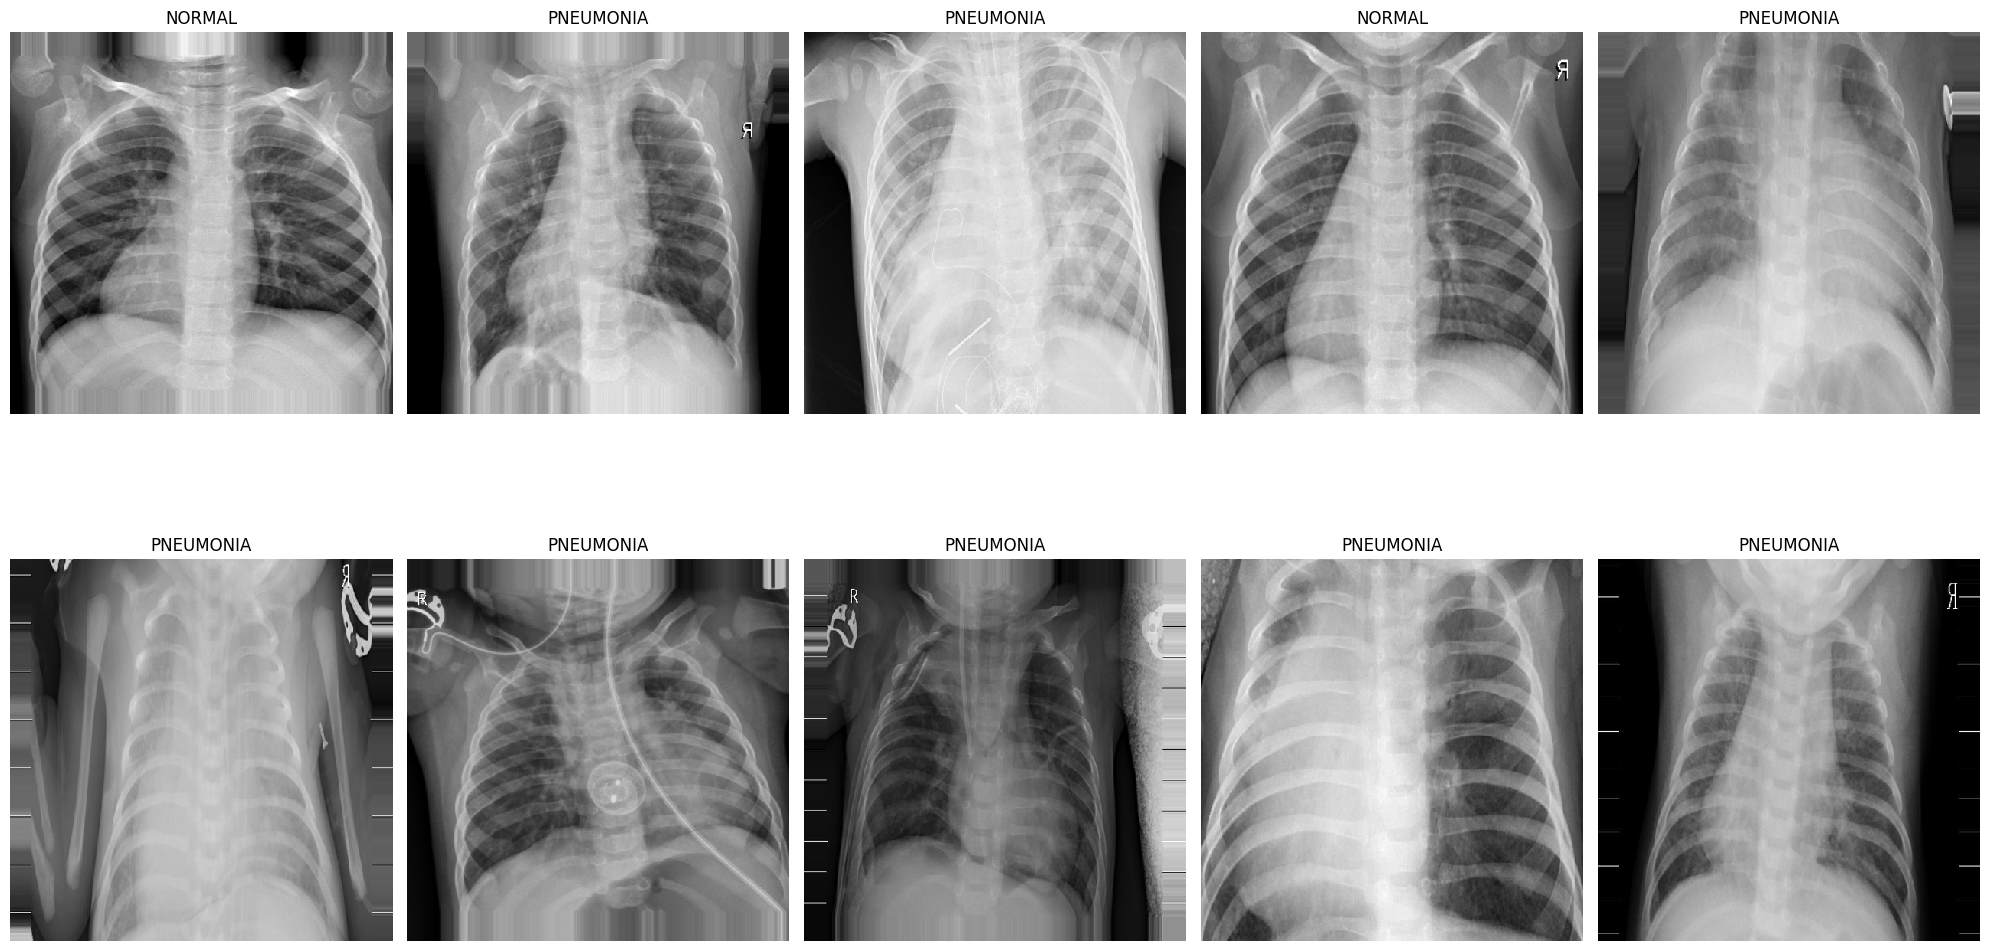

In [14]:
# display sample images from the training set with labels

plt.figure(figsize=(20, 12))  # define the overall figure size

for i in range(0, 10):
    plt.subplot(2, 5, i+1)  # create a 2x5 grid of subplots
    
    for X_batch, Y_batch in train:  # fetch one batch from the generator
        image = X_batch[0]          # get the first image in the batch
        label = Y_batch[0]          # get the corresponding label
        label_dict = {0: 'NORMAL', 1: 'PNEUMONIA'}
        
        plt.title(label_dict.get(label))  # set class name as title
        plt.axis('off')                   # remove axis ticks
        plt.imshow(np.squeeze(image), cmap='gray', interpolation='nearest')  # display grayscale image
        break  # display only one image per iteration

plt.tight_layout()
plt.show()

In [15]:
'''        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening

        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,# randomly flip images
        shear_range=0.2,
        brightness_range=(1.2, 1.5)'''

'        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # apply ZCA whitening\n\n        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)\n        zoom_range = 0.2, # Randomly zoom image\n        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)\n        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)\n        horizontal_flip = True,  # randomly flip images\n        vertical_flip=False,# randomly flip images\n        shear_range=0.2,\n        brightness_range=(1.2, 1.5)'

# **Part 7 - Neural Network Convolutional 1 Sequencial**


### **Convolutional Neural Network (CNN) Description**

The proposed architecture is a **deep Convolutional Neural Network (CNN)** structured as a **sequential model**, designed for **binary image classification** tasks using **grayscale images**. The model follows a classical structure based on convolution and pooling blocks, similar in style to a **VGG-like** architecture, with no branching or residual connections.


### **Layer-by-Layer Structure**

1. **Input**

   * The network receives input images of shape `(img_width, img_height, 1)`, i.e., grayscale images.

2. **Convolutional Blocks**

   * The network contains **5 sequential convolutional blocks**, each composed of:

     * A `Conv2D` layer with a `(3x3)` kernel and ReLU activation.
     * A `MaxPooling2D` layer with a `(2x2)` pool size.
   * The first three blocks use **32 filters**, while the last two use **64 filters**, enabling the extraction of increasingly complex features.

3. **Flatten Layer**

   * The output from the convolutional blocks is flattened using a `Flatten` layer, transforming the 3D feature maps into a 1D vector for the dense layers.

4. **Fully Connected (Dense) Layers**

   * The final part of the model consists of three dense layers:

     * A `Dense(128)` layer with ReLU activation.
     * A `Dense(64)` layer with ReLU activation.
     * A `Dense(1)` output layer with `sigmoid` activation to produce the binary classification probability.

5. **Compilation**

   * The model is compiled with:

     * Optimizer: `Adam`
     * Loss function: `binary_crossentropy`
     * Evaluation metric: `accuracy`

### **Technical Summary**

| Component          | Technical Details                                       |
| ------------------ | ------------------------------------------------------- |
| Network Type       | CNN (Convolutional Neural Network)                      |
| Architecture Style | Sequential, VGG-inspired                                |
| Input              | Grayscale images `(height, width, 1)`                   |
| Filters            | 32 → 64 filters across convolutional blocks             |
| Activation         | ReLU in hidden layers, Sigmoid in output                |
| Loss Function      | Binary Crossentropy                                     |
| Task               | Binary Classification                                   |
| Output             | Probability between 0 and 1 (positive class likelihood) |

### **Common Applications**

This architecture is commonly used for:

* Medical image classification (e.g., cancer or pneumonia detection).
* Binary pattern recognition (e.g., presence/absence of objects).
* Satellite imagery analysis, X-ray or ultrasound processing.

In [16]:
# define a custom Sequential Convolutional Neural Network (CNN)
model_cnn = Sequential()

# first convolutional layer with 32 filters, 3x3 kernel, ReLU activation
model_cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))  # downsampling

# second convolutional layer with 32 filters
model_cnn.add(Conv2D(32, (3, 3), activation="relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 32 filters
model_cnn.add(Conv2D(32, (3, 3), activation="relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# fourth convolutional layer with 64 filters
model_cnn.add(Conv2D(64, (3, 3), activation="relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# fifth convolutional layer with 64 filters
model_cnn.add(Conv2D(64, (3, 3), activation="relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# flatten the output before passing to dense layers
model_cnn.add(Flatten())

# fully connected layer with 128 units
model_cnn.add(Dense(128, activation='relu'))

# fully connected layer with 64 units
model_cnn.add(Dense(64, activation='relu'))

# output layer with sigmoid activation for binary classification
model_cnn.add(Dense(1, activation='sigmoid'))

# compile the model using Adam optimizer and binary cross-entropy loss
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# display the model architecture summary
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748358604.236697      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748358604.237379      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 498, 498, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 247, 247, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 123, 123, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 121, 121, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,467,137 (5.60 MB)

 Trainable params: 1,467,137 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

**Tuning the Neural Network (CNN) Model**

In [17]:
# define early stopping to prevent overfitting by monitoring validation loss
early = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3
)

# reduce learning rate when validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=1e-6
)

# compute class weights to handle imbalanced dataset
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)

# convert weights to dictionary format expected by Keras
cw = dict(zip(np.unique(train.classes), weights))

In [18]:
# define a list of callbacks (can be passed to .fit if needed)
# callbacks_list = [early, learning_rate_reduction]
# callbacks = callbacks_list

# train the CNN model
history_cnn = model_cnn.fit(
    train,
    epochs=50,
    validation_data=valid,
    class_weight=cw  # apply class weighting to handle imbalance
    # callbacks=callbacks_list  # optionally include callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1748358610.021226     124 service.cc:148] XLA service 0x7f6650012a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748358610.022231     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748358610.022252     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748358610.495236     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/262 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.4531 - loss: 0.8202 

I0000 00:00:1748358616.866323     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


262/262 ━━━━━━━━━━━━━━━━━━━━ 151s 540ms/step - accuracy: 0.6058 - loss: 0.6005 - val_accuracy: 0.8010 - val_loss: 0.4236
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 98s 375ms/step - accuracy: 0.8697 - loss: 0.2921 - val_accuracy: 0.9163 - val_loss: 0.2262
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 98s 373ms/step - accuracy: 0.8971 - loss: 0.2447 - val_accuracy: 0.9212 - val_loss: 0.1954
Epoch 4/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 97s 370ms/step - accuracy: 0.8945 - loss: 0.2334 - val_accuracy: 0.9163 - val_loss: 0.1997
Epoch 5/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 97s 370ms/step - accuracy: 0.9148 - loss: 0.2023 - val_accuracy: 0.9163 - val_loss: 0.2026
Epoch 6/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 98s 374ms/step - accuracy: 0.8991 - loss: 0.2580 - val_accuracy: 0.9125 - val_loss: 0.2277
Epoch 7/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 97s 371ms/step - accuracy: 0.9363 - loss: 0.1649 - val_accuracy: 0.9212 - val_loss: 0.2118
Epoch 8/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 96s 368ms/step - accuracy: 0.9359 - loss: 0.1646 - va

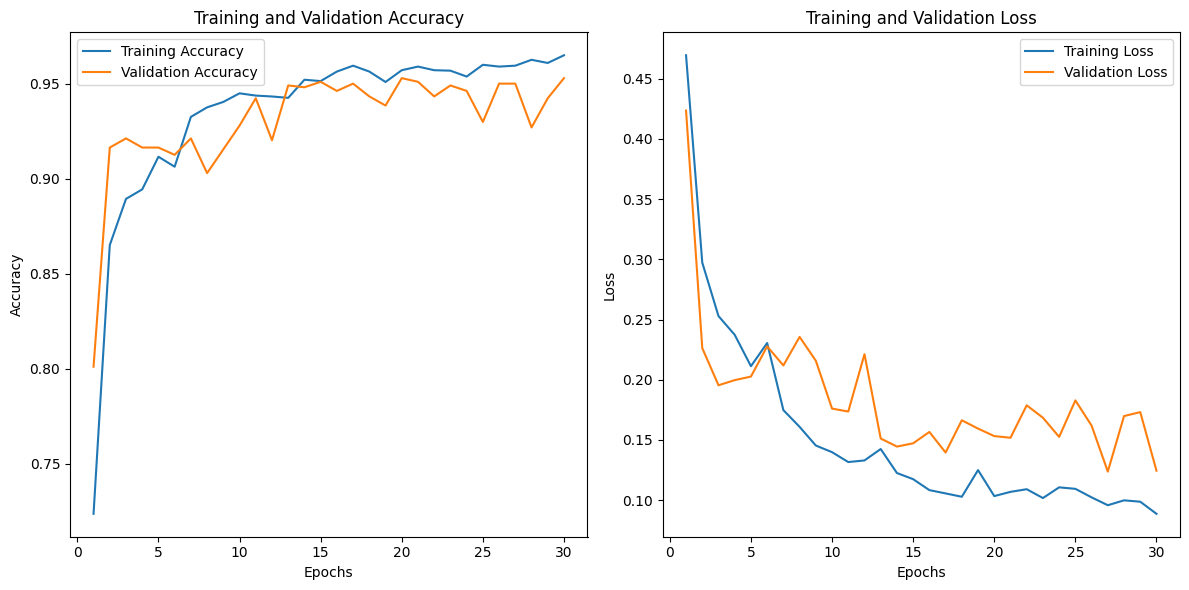

In [19]:
# function to plot training and validation accuracy/loss over epochs
def plot_training_history(history):
    # extract training and validation metrics from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    # plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy - CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss - CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# call the function to display training history plots
plot_training_history(history_cnn)

In [20]:
# define file path for saving the model in .keras format (recommended for TensorFlow 2.x+)
fp = "cnn_pneu_vamp_model.keras"
model_cnn.save(fp)  # save model in the newer .keras format

# load the saved model from the .keras file
cnn = load_model(fp)

# save the model in HDF5 (.h5) format for compatibility with older tools
model_cnn.save('CNN_Classification_1.h5')

# alternative way to save using save_model() function explicitly
save_model(model_cnn, 'CNN_Classification_2.h5')

# **Part 8 - Neural Network Evaluation**

In [24]:
preds = cnn.predict(test,verbose=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step


In [25]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8693 - loss: 0.4384
The testing accuracy is : 90.86538553237915 %


In [26]:
# convert predicted probabilities to binary class labels (threshold at 0.5)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

# reset the test generator so it starts from the beginning
test.reset()

# concatenate all images and true labels from the test generator
x = np.concatenate([test.__next__()[0] for i in range(len(test))])  # all test images
y = np.concatenate([test.__next__()[1] for i in range(len(test))])  # all ground truth labels

# print shapes for confirmation
print(x.shape)  # shape: (num_samples, height, width, channels)
print(y.shape)  # shape: (num_samples,)

(624, 500, 500, 1)
(624,)


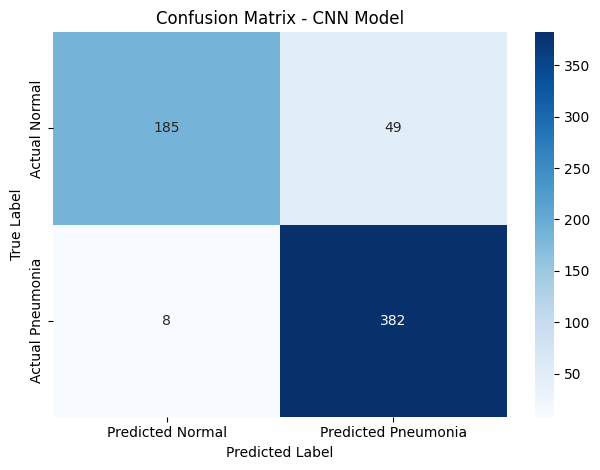

In [115]:
# create a confusion matrix DataFrame
cm = pd.DataFrame(
    data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
    index=["Actual Normal", "Actual Pneumonia"],         # true labels
    columns=["Predicted Normal", "Predicted Pneumonia"]  # predicted labels
)

# plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [116]:
# generate a classification report including precision, recall, F1-score, and support for each class
print(classification_report(
    y_true=test.classes,          # true labels from the test set
    y_pred=predictions,           # predicted labels from the model
    target_names=['NORMAL', 'PNEUMONIA']  # human-readable class names
))

              precision    recall  f1-score   support

      NORMAL       0.96      0.79      0.87       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



# **Part 9 - Image Preview**

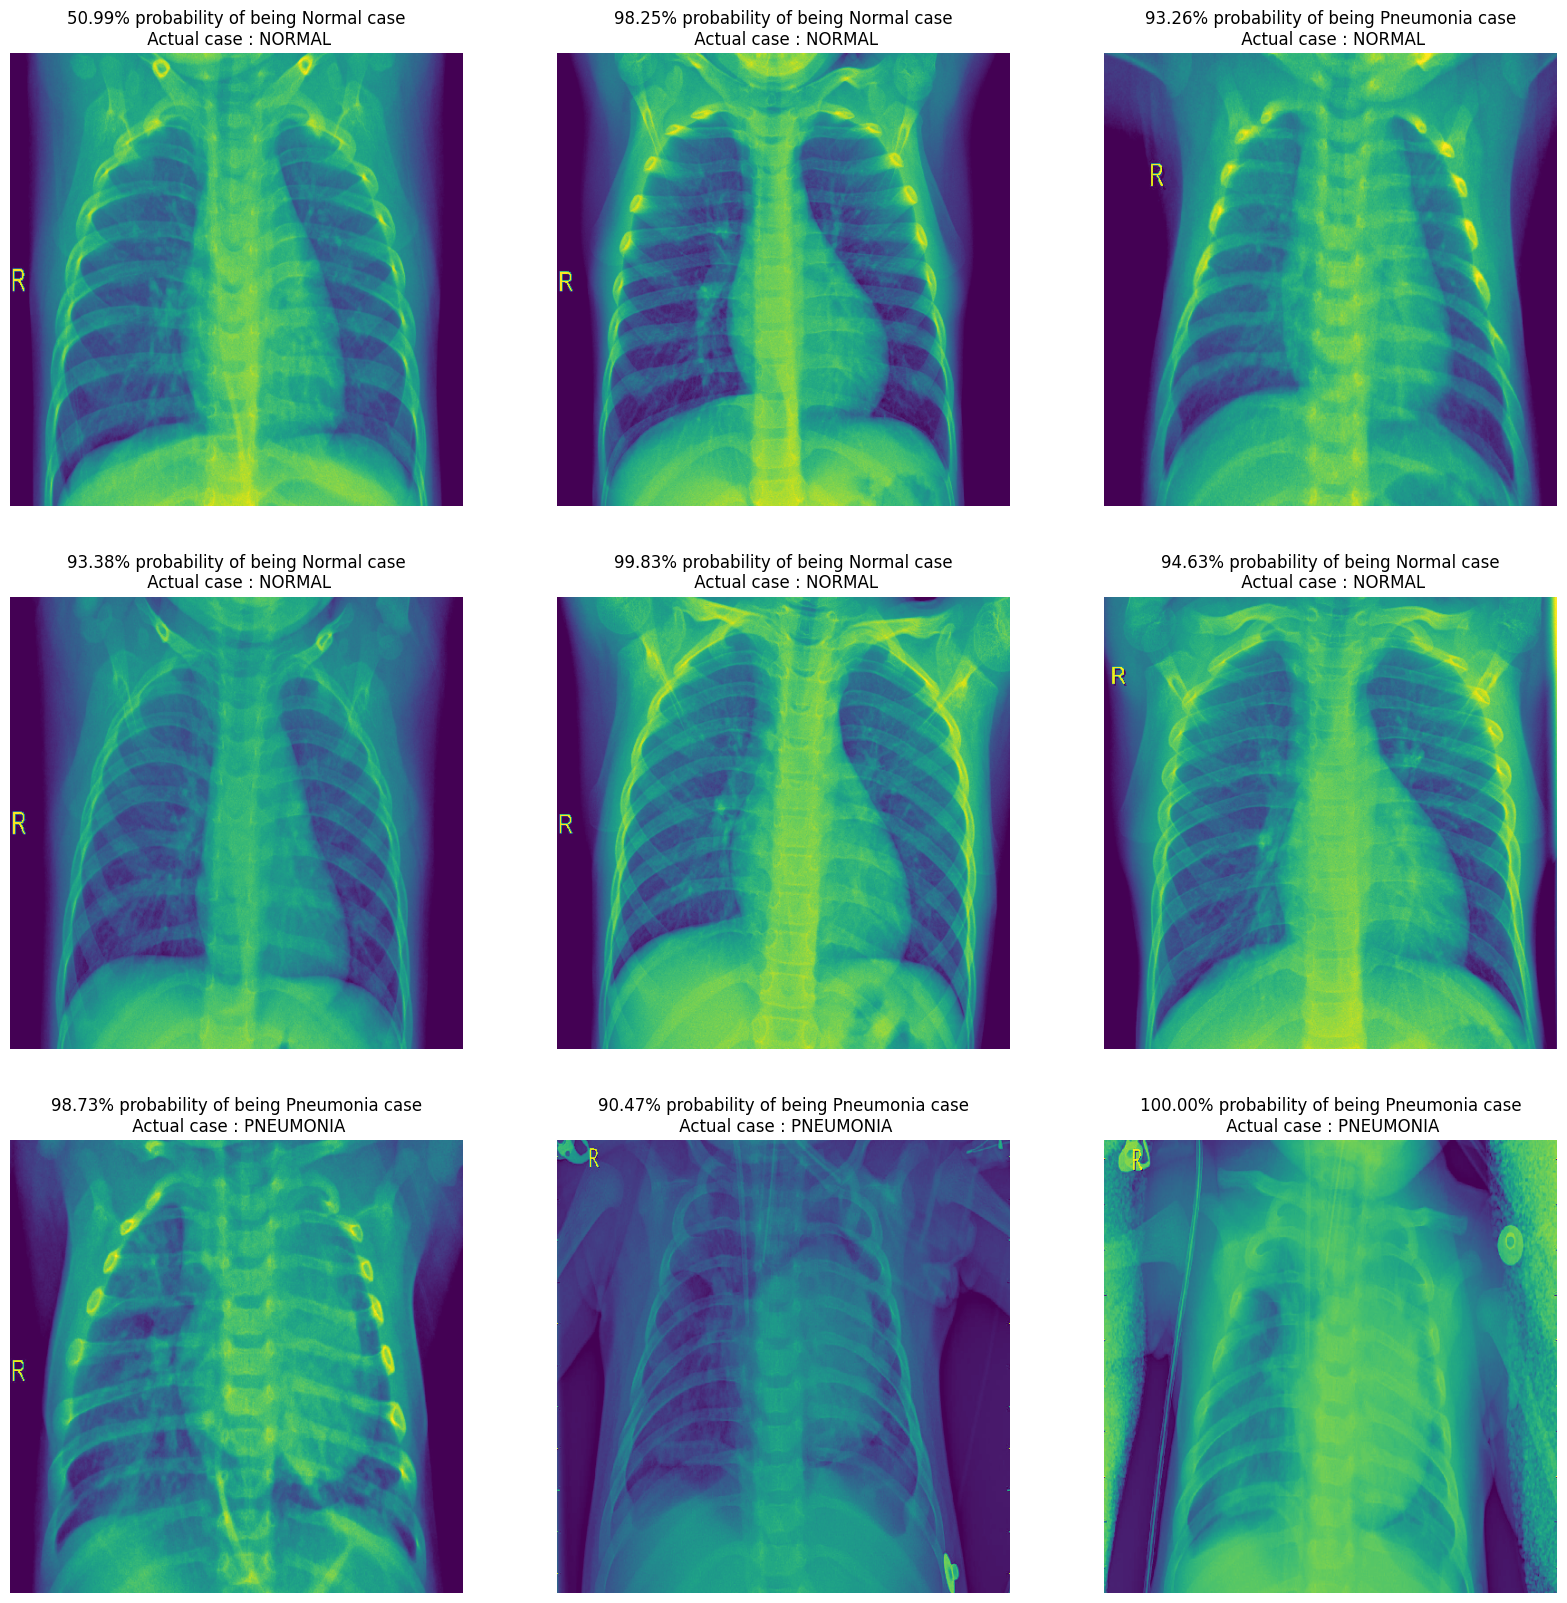

In [29]:
# dictionary to map class labels to readable text
dic = {0: 'NORMAL', 1: 'PNEUMONIA'}

# set up the figure size for displaying images
plt.figure(figsize=(20, 20))

# loop through 9 test images starting from index 228
for i in range(0 + 228, 9 + 228):
    plt.subplot(3, 3, (i - 228) + 1)  # create a 3x3 grid of subplots

    # generate prediction text with probability
    if preds[i, 0] >= 0.5:
        out = '{:.2%} probability of being Pneumonia case'.format(preds[i][0])
    else:
        out = '{:.2%} probability of being Normal case'.format(1 - preds[i][0])

    # set the title with predicted probability and actual class label
    plt.title(out + "\nActual case: " + dic.get(y[i]))

    # display the image (remove singleton dimension)
    plt.imshow(np.squeeze(x[i]), cmap='gray')
    plt.axis('off')

# display the full grid
plt.show()

# **Part 9 - Neural Network 2 VGG16**

**VGG16 Model – Description**

**VGG16** is a deep **Convolutional Neural Network (CNN)** architecture developed by the Visual Geometry Group (VGG) at the University of Oxford. It became widely known after achieving excellent performance in the **ImageNet Large Scale Visual Recognition Challenge (ILSVRC)** in 2014.

**Architecture Overview**

* **Total Layers**: 16 weight layers

  * 13 Convolutional Layers
  * 3 Fully Connected (Dense) Layers
* All convolutional layers use **3×3 filters**, stride 1, and **'same' padding**.
* **MaxPooling** is applied after specific convolutional blocks using **2×2 filters** and stride 2.
* The network ends with three **Dense layers**:

  * Two with 4096 units and ReLU activation
  * One with 1000 units and softmax activation (for ImageNet classification)

**Block-wise Structure**

| Block | Layers                                      | Filters            |
| ----- | ------------------------------------------- | ------------------ |
| 1     | Conv3-64 → Conv3-64 → MaxPool               | 64                 |
| 2     | Conv3-128 → Conv3-128 → MaxPool             | 128                |
| 3     | Conv3-256 → Conv3-256 → Conv3-256 → MaxPool | 256                |
| 4     | Conv3-512 → Conv3-512 → Conv3-512 → MaxPool | 512                |
| 5     | Conv3-512 → Conv3-512 → Conv3-512 → MaxPool | 512                |
| FC    | Dense → Dense → Dense                       | 4096 → 4096 → 1000 |


**Key Characteristics**

* **Deep but simple**: Uses only 3×3 convolutions, stacked to increase the receptive field.
* **High performance**: Achieved top-5 test accuracy of **92.7%** on ImageNet.
* **Transfer learning friendly**: VGG16 is widely used as a base model for other vision tasks (e.g., classification, detection, segmentation).
* **Input size**: Expects images of shape **(224, 224, 3)**.


**Use Cases**

* Medical imaging (e.g., pneumonia or cancer classification)
* Industrial visual inspection
* Satellite or aerial image classification
* Transfer learning in low-data environments


**Limitations**

* **Very large**: \~138 million parameters
* **Slow to train** and memory-intensive compared to more modern architectures like ResNet or EfficientNet
* **No residual or attention mechanisms**


**Conclusion**

VGG16 is a **foundational CNN architecture** known for its simplicity and strong performance. While newer architectures may be more efficient, VGG16 remains a **go-to choice for transfer learning** and benchmarking due to its reliable feature extraction capabilities.

**Architecture Deep convolutional neural network**

* Only **3×3 convolution filters** with stride 1
* **2×2 max pooling** with stride 2
* A stack of **convolutional layers followed by fully connected layers**
* ReLU as the activation function
* Softmax for final classification (in multi-class settings)

**Layer-by-Layer Mathematical Structure of VGG16**

Let’s define:

* $X$: input image of size $H \times W \times C$
* $W^l, b^l$: weight and bias of layer $l$
* $Z^l$: pre-activation at layer $l$
* $A^l$: activation (output) at layer $l$
* $\sigma$: activation function (ReLU, Softmax)

**1. Convolutional Layer (for each Conv3×3 layer)**

For an input patch $X \in \mathbb{R}^{k \times k \times C}$, the convolution operation computes:

$$
Z_{i,j}^{(l)} = \sum_{m=1}^{k} \sum_{n=1}^{k} \sum_{c=1}^{C} X_{i+m, j+n, c} \cdot W_{m,n,c}^{(l)} + b^{(l)}
$$

Then apply **ReLU activation**:

$$
A_{i,j}^{(l)} = \text{ReLU}(Z_{i,j}^{(l)}) = \max(0, Z_{i,j}^{(l)})
$$

Each convolutional block contains 2 or 3 layers like this, with increasing filters:

* Block 1: 64 filters
* Block 2: 128 filters
* Block 3: 256 filters
* Block 4 & 5: 512 filters

**2. Max Pooling Layer**

After each block, the spatial resolution is halved by max pooling:

$$
A^{(l+1)}_{i,j} = \max_{(m,n) \in P} A^{(l)}_{2i+m, 2j+n}
$$

Where $P$ is a 2×2 window.

**3. Flatten Layer**

After the final convolution + pooling block, the 3D feature map is **flattened** into a vector $x \in \mathbb{R}^{N}$, where:

$$
x = \text{Flatten}(A^{(final)})
$$

**4. Fully Connected Layers (Dense)**

There are **3 dense layers**:

* Two layers with 4096 units + ReLU
* One final layer with 1000 units + Softmax (in original ImageNet)

Each dense layer computes:

$$
z^{(l)} = W^{(l)} x^{(l-1)} + b^{(l)}
$$

$$
a^{(l)} = \sigma(z^{(l)})
$$

Where:

* $\sigma = \text{ReLU}$ for the first two FC layers
* $\sigma = \text{Softmax}$ for classification:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$$


**5. Loss Function – Categorical Crossentropy (for 1000 classes)**

$$
\mathcal{L} = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Where:

* $y_i$: true one-hot encoded label
* $\hat{y}_i$: predicted probability from softmax output

**Summary Table – Mathematical Operations in VGG16**

| Layer Type         | Formula                                              |
| ------------------ | ---------------------------------------------------- |
| Conv2D             | $Z = X * W + b$, $A = \text{ReLU}(Z)$                |
| MaxPooling2D       | $A_{i,j} = \max(A^{\text{window}})$                  |
| Flatten            | $x = \text{Flatten}(A)$                              |
| Dense (FC)         | $z = W x + b$, $a = \sigma(z)$                       |
| Softmax            | $\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$ |
| Loss (Categorical) | $\mathcal{L} = -\sum y_i \log(\hat{y}_i)$            |

In [35]:
# repeated configuration parameters
batch_size = 16
img_height = 500
img_width = 500
input_shape = (img_height, img_width, 3)  # VGG16 expects 3 input channels (RGB)


In [36]:
# convert grayscale (1 channel) images to RGB by duplicating the channel
def grayscale_to_rgb(gen):
    for x, y in gen:
        yield np.repeat(x, 3, axis=-1), y

# apply grayscale-to-RGB conversion to each generator
train_rgb = grayscale_to_rgb(train)
valid_rgb = grayscale_to_rgb(valid)
test_rgb  = grayscale_to_rgb(test)

In [38]:
# import required components
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# load the VGG16 base model without the top layer (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [39]:
# build a custom classification head on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # binary classification

# define the full model
model2 = Model(inputs=base_model.input, outputs=output)

# compile the model with Adam optimizer and binary crossentropy loss
model2.compile(optimizer=Adam(learning_rate=1e-4),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# display model architecture
model2.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 500, 500, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 500, 500, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 500, 500, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 250, 250, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 250, 250, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 250, 250, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 125, 125, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 125, 125, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 125, 125, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 125, 125, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 62, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 62, 62, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 62, 62, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 62, 62, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 44,222,657 (168.70 MB)

 Trainable params: 44,222,657 (168.70 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# define callbacks for early stopping and dynamic learning rate reduction
early = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=1e-6)

# compute class weights to handle dataset imbalance
weights = compute_class_weight(class_weight='balanced',
                                classes=np.unique(train.classes),
                                y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))

In [ ]:
# define steps per epoch
steps_per_epoch = train.samples // batch_size
val_steps = valid.samples // batch_size

In [43]:
%%time

# ⏱️ training the model

history = model2.fit(
    train_rgb,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_rgb,
    validation_steps=val_steps,
    epochs=30,
    class_weight=cw,
    callbacks=[early, lr_reduction]
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Epoch 1/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.9517 - loss: 0.1225 - val_accuracy: 0.9596 - val_loss: 0.1236
Epoch 2/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9551 - loss: 0.1192 - val_accuracy: 0.9500 - val_loss: 0.1233
Epoch 3/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.9653 - loss: 0.0984 - val_accuracy: 0.9654 - val_loss: 0.0945
Epoch 4/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.9679 - loss: 0.0906 - val_accuracy: 0.9567 - val_loss: 0.1176
Epoch 5/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.9619 - loss: 0.1033 - val_accuracy: 0.9615 - val_loss: 0.0892


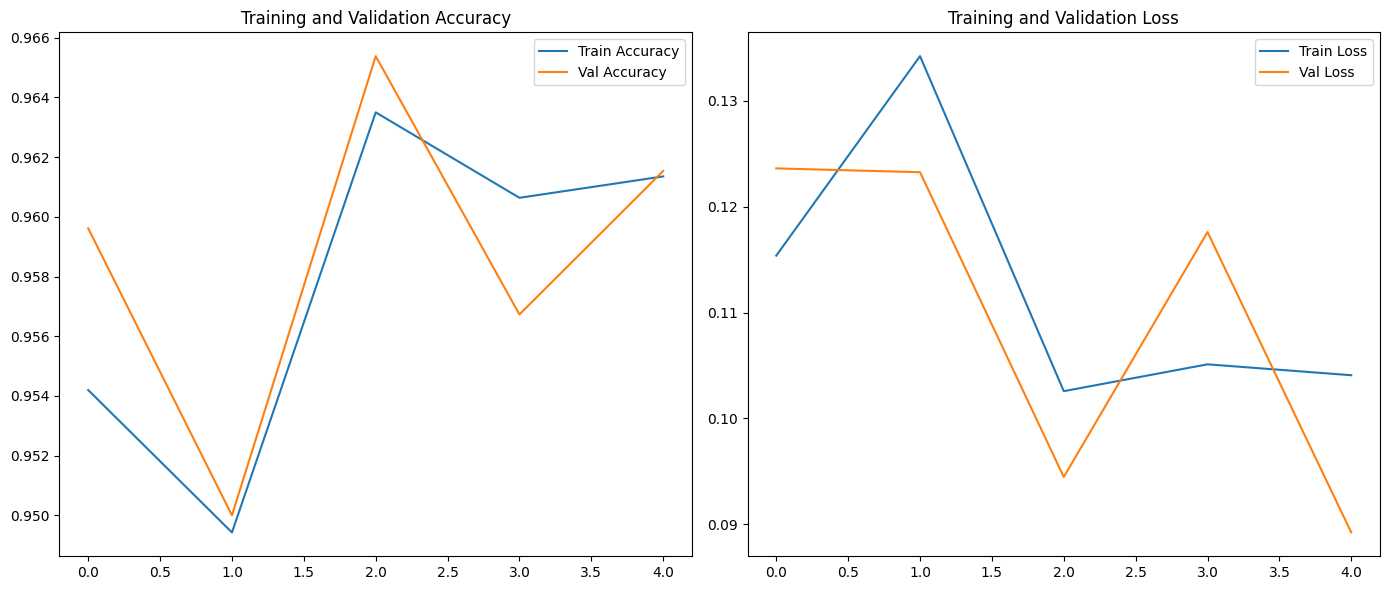

In [44]:
# Plot accuracy e loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

#
plot_training(history)

In [45]:
# get model predictions on the test set
y_true = test.classes  # true labels
y_pred_probs = model2.predict(test_rgb, steps=len(test), verbose=1)  # predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # apply threshold to get class labels

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step


In [46]:
# classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test.class_indices.keys()))

Classification Report:

              precision    recall  f1-score   support

      normal       0.97      0.70      0.81       234
     opacity       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



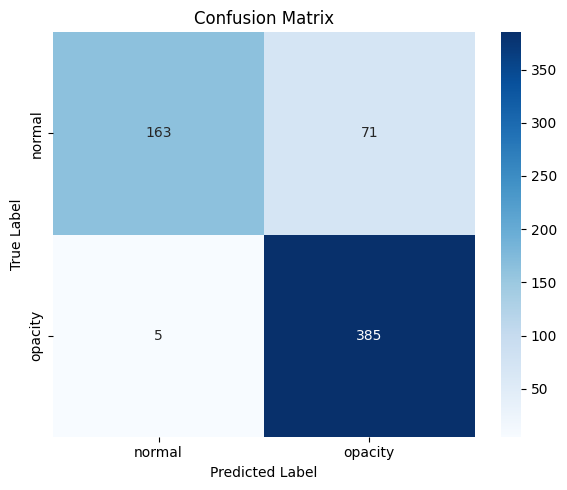

In [47]:
# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test.class_indices.keys(),
            yticklabels=test.class_indices.keys())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [49]:
# make predictions on a single batch (e.g., 16 test images)
x_test, y_test = next(test)
x_test_rgb = np.repeat(x_test, 3, axis=-1)  # ensure 3 channels for RGB input
y_pred_batch = model2.predict(x_test_rgb)
y_pred_label = (y_pred_batch > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# class names for display
class_names = list(test.class_indices.keys())

In [ ]:
# Pegando imagens e rótulos verdadeiros
x_test, y_test = next(test)
x_test_rgb = np.repeat(x_test, 3, axis=-1)  # garantir 3 canais

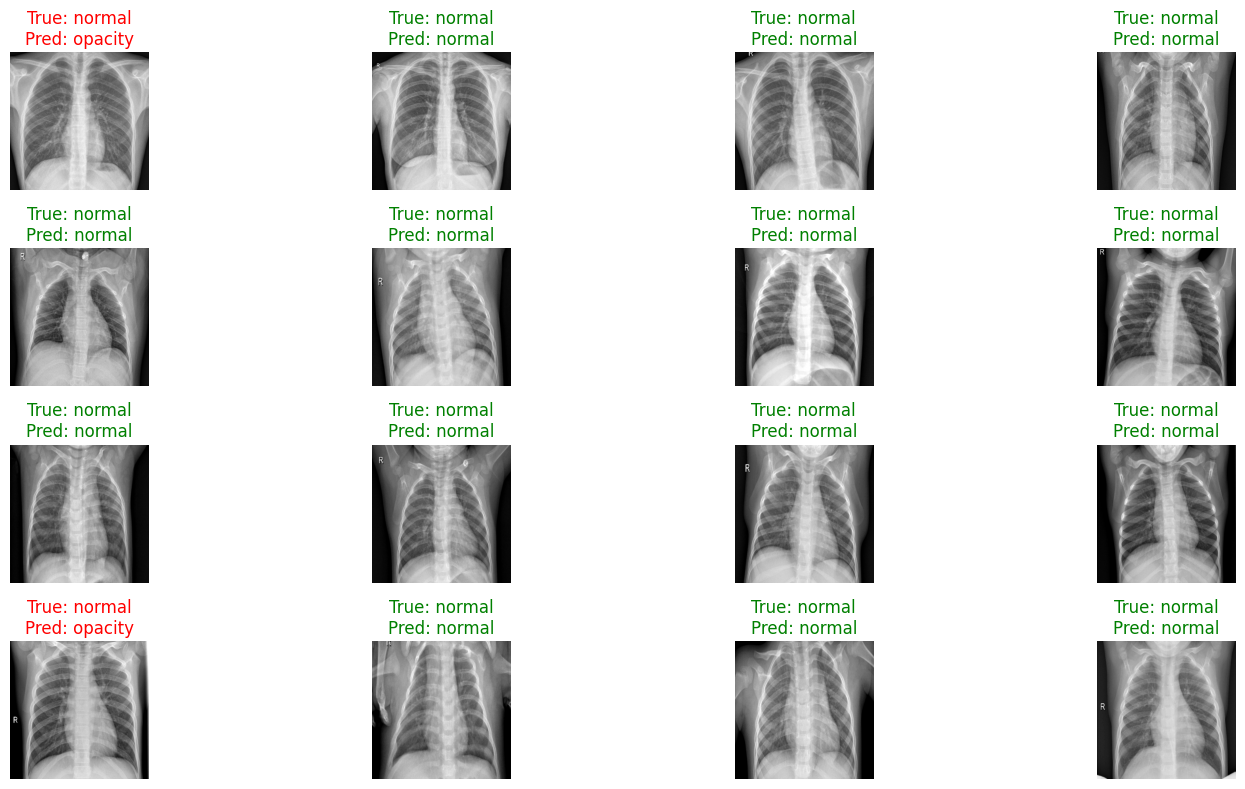

In [50]:
# plot predictions with true vs predicted labels
plt.figure(figsize=(16, 8))
for i in range(len(x_test)):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    true_label = class_names[int(y_test[i])]
    pred_label = class_names[int(y_pred_label[i])]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
plt.tight_layout()
plt.show()

In [53]:
# import metric functions
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# calculate evaluation metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

# create a dictionary of metrics
metrics_dict = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1 Score': f1
}

# create a single-row DataFrame for display or saving
df_metrics_simple = pd.DataFrame([metrics_dict])

# display the metrics DataFrame
df_metrics_simple

Accuracy  Precision    Recall  F1 Score
0  0.878205   0.844298  0.987179  0.910165

# **Part 10 - Neural Network 3 ImageNet**

**ImageNet – Description**

**ImageNet** is a large-scale visual database designed for use in **visual object recognition research**. It contains **millions of annotated images** organized according to the **WordNet hierarchy**, where each node in the hierarchy is depicted by hundreds or thousands of images.


### **Key Features**

* **Size**: Over **14 million images**
* **Annotations**: Each image is manually labeled with one or more object categories.
* **Structure**: Follows the **WordNet** lexical database structure, with categories like animals, tools, scenes, etc.
* **Classes**: More than **21,000 object categories**, with **1,000 classes** commonly used in competitions and pretrained models.

### **ILSVRC – ImageNet Challenge**

The **ImageNet Large Scale Visual Recognition Challenge (ILSVRC)**, held annually between 2010 and 2017, was a major benchmark for evaluating image classification and object detection models.

* **Standard Task**: Classify images into one of **1,000 categories**.
* **Evaluation Metric**: Top-1 and Top-5 accuracy.
* **Breakthroughs**:

  * **AlexNet (2012)**: Reduced top-5 error rate significantly with deep learning.
  * **VGG (2014)**, **GoogLeNet/Inception**, **ResNet (2015)** further advanced performance.

### **Use in Deep Learning**

* **Pretraining Dataset**: Most modern deep learning models for image analysis are **pretrained on ImageNet** and then fine-tuned for specific tasks (transfer learning).
* **Benchmark Standard**: ImageNet is the **de facto benchmark** for comparing the performance of convolutional neural networks (CNNs).
* **Generalization**: Pretrained ImageNet models generalize well across diverse domains, including:

  * Medical imaging
  * Satellite imagery
  * Industrial inspection
  * Natural scene classification

### **Why It Matters**

* **Diversity**: Covers a wide variety of objects, scenes, and categories.
* **Scalability**: Facilitated the rise of deeper architectures like ResNet, DenseNet, Inception, etc.
* **Transferability**: Enabled the practice of **transfer learning**, which significantly reduces training time and improves performance in domain-specific tasks.

### **Access and Usage**

* Dataset access: [http://www.image-net.org](http://www.image-net.org)
* Requires registration for full download access due to licensing constraints.


### **Conclusion**

**ImageNet** is one of the most important resources in computer vision and deep learning history. It has powered nearly every major advancement in CNN architectures, making it essential for training, benchmarking, and transfer learning in modern AI workflows.

**Convolutional Neural Networks (CNNs) – ImageNet Models**

**Convolutional Layer (Conv2D)**

Convolutions extract **local patterns** from the image. The output of a convolutional neuron is computed as:

$$
z = \sum_{i=1}^{k} \sum_{j=1}^{k} x_{i,j} \cdot w_{i,j} + b
$$

* $x_{i,j}$: pixel value at position $(i,j)$ in the input window
* $w_{i,j}$: weight in the kernel (filter)
* $b$: bias term
* $k$: filter size (e.g., 3×3)

The output is then passed through an **activation function**, commonly ReLU:

$$
a = \text{ReLU}(z) = \max(0, z)
$$

**Pooling Layer (MaxPooling2D)**

**Max pooling** reduces the spatial dimensions by taking the maximum value within a local window:

$$
a_{pooled} = \max\{a_{i,j} \in \text{window } (p \times p)\}
$$

Where $p$ is the pooling window size (e.g., $2 \times 2$).


**Convolutional Output Size**

To compute the **output dimension** of a convolutional layer:

$$
\text{Output Size} = \left( \frac{N - F + 2P}{S} \right) + 1
$$

* $N$: input size (height or width)
* $F$: filter size
* $P$: padding
* $S$: stride

**Fully Connected Layer (Dense Layer)**

In dense layers, the operation is similar to traditional neural networks:

$$
z = \sum_{i=1}^{n} x_i \cdot w_i + b \quad \text{and} \quad a = \phi(z)
$$

* $\phi$ can be ReLU, sigmoid, or softmax.
* For **binary classification**:

  $$
  \phi(z) = \sigma(z) = \frac{1}{1 + e^{-z}}
  $$
* For **multi-class classification** (e.g., ImageNet with 1000 classes):

  $$
  \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
  $$


**Loss Functions – Binary Crossentropy / Categorical Crossentropy**

**Binary Crossentropy** (for 2-class problems like pneumonia detection):

$$
\mathcal{L} = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

**Categorical Crossentropy** (for ImageNet with 1000 classes):

$$
\mathcal{L} = - \sum_{i=1}^{C} y_i \cdot \log(\hat{y}_i)
$$

**Backpropagation (Gradient Update)**

The gradient of the loss with respect to weights enables the network to learn:

$$
\frac{\partial \mathcal{L}}{\partial w} = \frac{\partial \mathcal{L}}{\partial a} \cdot \frac{\partial a}{\partial z} \cdot \frac{\partial z}{\partial w}
$$

The weights are updated using gradient descent:

$$
w = w - \eta \cdot \frac{\partial \mathcal{L}}{\partial w}
$$

Where $\eta$ is the **learning rate**.

**Summary Table – Key CNN Formulas**

| Component        | Formula                                                          |
| ---------------- | ---------------------------------------------------------------- |
| Convolution      | $z = \sum x \cdot w + b$, $a = \max(0, z)$ (ReLU)                |
| Pooling          | $a_{pooled} = \max(a_{i,j})$                                     |
| Conv Output Size | $\left( \frac{N - F + 2P}{S} \right) + 1$                        |
| Dense Layer      | $z = \sum x \cdot w + b$, $a = \sigma(z)$ or $\text{softmax}(z)$ |
| Binary Loss      | $\mathcal{L} = -[y \log \hat{y} + (1 - y)\log(1 - \hat{y})]$     |
| Categorical Loss | $\mathcal{L} = - \sum y_i \log \hat{y}_i$                        |
| Weight Update    | $w = w - \eta \cdot \frac{\partial \mathcal{L}}{\partial w}$     |

In [58]:
# ✅ Load ResNet50 architecture and training pipeline

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [59]:
# input shape: 500x500 with 3 channels (RGB)
input_shape = (img_height, img_width, 3)

# load base ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


In [60]:
# freeze all layers in the base model (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

In [61]:
# add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

# define the full model
model_resnet = Model(inputs=base_model.input, outputs=output)

# compile the model
model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# display model summary
model_resnet.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 500, 500, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 506, 506, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 250, 250, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 250, 250, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 250, 250, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 252, 252, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 125, 125, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 125, 125, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 125, 125, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 125, 125, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 125, 125, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 125, 125, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 125, 125, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 125, 125, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 125, 125, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:
%%time

# Train the model
%%time
history_resnet = model_resnet.fit(
    train_rgb,
    steps_per_epoch=train.samples // batch_size,
    validation_data=valid_rgb,
    validation_steps=valid.samples // batch_size,
    epochs=30
)

Epoch 1/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 156s 524ms/step - accuracy: 0.7046 - loss: 0.6536 - val_accuracy: 0.7452 - val_loss: 0.5577
Epoch 2/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 128s 489ms/step - accuracy: 0.7413 - loss: 0.5776 - val_accuracy: 0.7452 - val_loss: 0.5588
Epoch 3/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 123s 469ms/step - accuracy: 0.7429 - loss: 0.5686 - val_accuracy: 0.7519 - val_loss: 0.5607
Epoch 4/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 122s 466ms/step - accuracy: 0.7445 - loss: 0.5652 - val_accuracy: 0.7394 - val_loss: 0.5518
Epoch 5/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 120s 458ms/step - accuracy: 0.7538 - loss: 0.5453 - val_accuracy: 0.7394 - val_loss: 0.5485


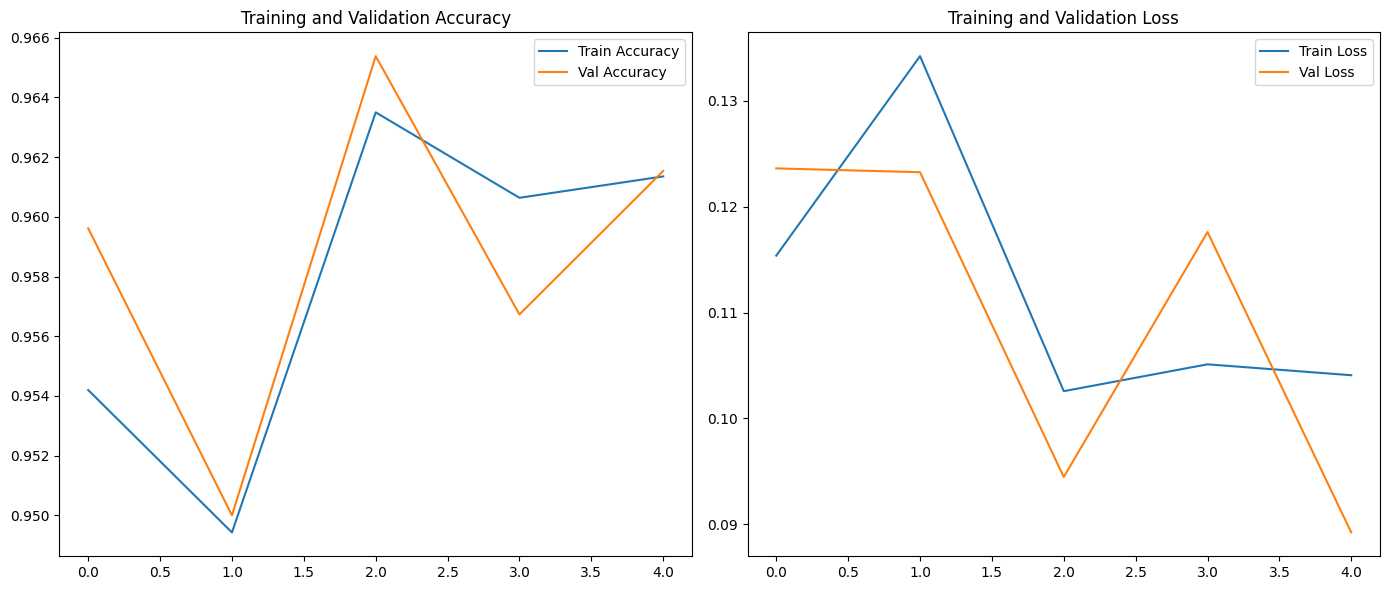

In [63]:
# 📈 Plot training curves
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history_resnet)

In [64]:
# 📊 Evaluate model on test set
y_pred_probs = model_resnet.predict(test_rgb, steps=len(test), verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test.classes

39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step


In [65]:
# compute evaluation metrics manually
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

# create a DataFrame with ResNet metrics
df_metrics_resnet = pd.DataFrame([{
    'Model': 'ResNet50',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1 Score': f1
}])

# display ResNet performance
df_metrics_resnet

Model  Accuracy  Precision  Recall  F1 Score
0  ResNet50     0.625      0.625     1.0  0.769231

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


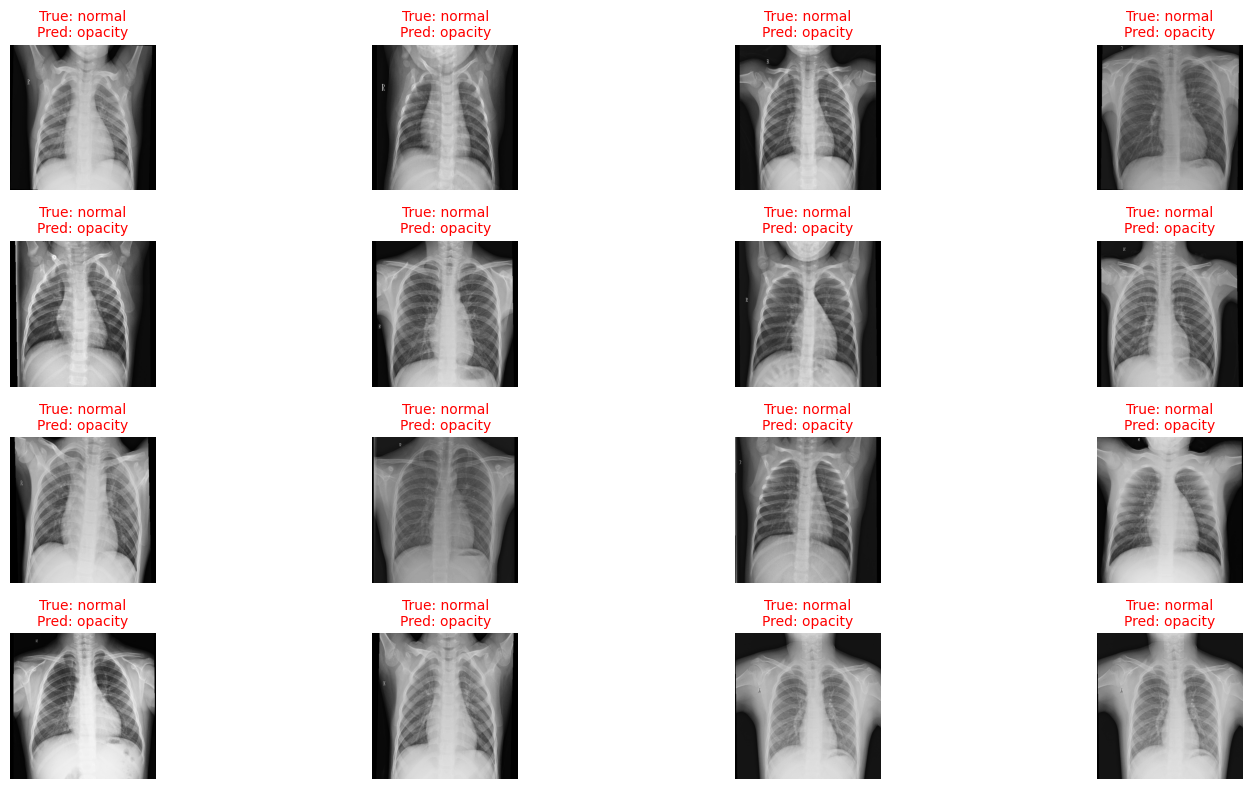

In [66]:
# 🖼️ Visualize predictions for a batch of test images
x_test_batch, y_test_batch = next(test)
x_test_rgb = np.repeat(x_test_batch, 3, axis=-1)  # ensure 3-channel input

y_pred_probs_batch = model_resnet.predict(x_test_rgb)
y_pred_labels = (y_pred_probs_batch > 0.5).astype(int).flatten()

class_names = list(test.class_indices.keys())

plt.figure(figsize=(16, 8))
for i in range(len(x_test_batch)):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_test_batch[i].squeeze(), cmap='gray')
    plt.axis('off')

    true_label = class_names[int(y_test_batch[i])]
    pred_label = class_names[int(y_pred_labels[i])]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=10)

plt.tight_layout()
plt.show()

In [67]:
# 🧾 Compare metrics from ResNet and VGG16
df_all = pd.concat([df_metrics_simple, df_metrics_resnet], ignore_index=True)
df_all

Accuracy  Precision    Recall  F1 Score     Model
0  0.878205   0.844298  0.987179  0.910165       NaN
1  0.625000   0.625000  1.000000  0.769231  ResNet50

# **Part 11 - Neural Network 4 ResNet**

**ResNet – Residual Neural Network**

**ResNet** (Residual Neural Network) is a **deep convolutional neural network (CNN)** architecture introduced by **Kaiming He et al.** in 2015. It was designed to solve the **degradation problem** that occurs when deep networks start to **lose accuracy as layers are added**.

ResNet enables the training of **extremely deep networks** (e.g., 50, 101, 152 layers) by introducing **residual connections**, also known as **skip connections**, which allow gradients to flow directly through the network during backpropagation.

**Key Concept: Residual Learning**

Traditional CNNs aim to learn a direct mapping $H(x)$ from input to output. ResNet reformulates this as:

$$
H(x) = F(x) + x
$$

Where:

* $F(x)$ is the **residual function** (what the network actually learns),
* $x$ is the input (passed through the shortcut connection),
* $H(x)$ is the final output of the residual block.

This identity shortcut allows the model to **preserve information and gradients**, making it easier to train deep networks.

**ResNet Architecture Variants**

| Model      | Depth | # Parameters | Use Case                               |
| ---------- | ----- | ------------ | -------------------------------------- |
| ResNet-18  | 18    | \~11M        | Lightweight applications               |
| ResNet-34  | 34    | \~21M        | Medium complexity                      |
| ResNet-50  | 50    | \~25M        | Common in ImageNet / Transfer Learning |
| ResNet-101 | 101   | \~44M        | Advanced computer vision tasks         |
| ResNet-152 | 152   | \~60M        | Very deep, high-performance models     |

**Characteristics of ResNet**

* **Skip connections** mitigate vanishing gradient problems.
* Enables **training of very deep models** efficiently.
* Uses **Batch Normalization** after each convolution.
* Standardized use of **ReLU activation**.
* Final layers use **Global Average Pooling + Dense + Softmax (or Sigmoid)**.

**Common Applications**

* Image classification (e.g., ImageNet)
* Medical imaging (e.g., cancer detection)
* Object detection and segmentation (e.g., Mask R-CNN uses ResNet backbone)
* Transfer learning on small or unbalanced datasets

**Summary Definition**

> **ResNet is a deep convolutional neural network that introduces residual connections to enable the effective training of very deep architectures. By learning residual functions instead of direct mappings, ResNet overcomes the degradation problem and has become one of the most influential models in modern computer vision.**

**ResNet (Residual Neural Network)**

ResNet (e.g., ResNet-50, ResNet-101) introduced **residual learning** to train **very deep neural networks** by solving the degradation problem using **skip connections**.


**Key Innovation: Residual Block**

In traditional CNNs, each layer learns a direct mapping $H(x)$.
**ResNet** reformulates this as learning a **residual function**:

$$
H(x) = F(x) + x
$$

* $x$: input to the block
* $F(x)$: residual function (typically two or three convolutional layers)
* $H(x)$: output after the residual block
* The term $x$ is passed through the **identity shortcut (skip connection)**

**Residual Block with Two Layers**

Assume:

* $x \in \mathbb{R}^{H \times W \times C}$
* $W_1, W_2$: weights of Conv layers
* $b_1, b_2$: biases

Then:

$$
F(x) = \text{ReLU}(\text{BN}(W_2 * \text{ReLU}(\text{BN}(W_1 * x + b_1)) + b_2))
$$

$$
H(x) = F(x) + x
$$

> If the dimensions of $F(x)$ and $x$ do not match, a **projection shortcut** is applied:

$$
H(x) = F(x) + W_s x
$$

Where $W_s$ is a $1 \times 1$ convolution (used for matching channels/dimensions).

**Stacking Residual Blocks**

A typical ResNet-50 architecture contains:

* **Convolutional stem**: Conv → BN → ReLU → MaxPool
* **4 stages** of residual blocks with increasing depth:

  * Stage 1: 64 filters
  * Stage 2: 128 filters
  * Stage 3: 256 filters
  * Stage 4: 512 filters

Each stage contains **multiple residual blocks**.

**Backpropagation in Residual Networks**

Residual blocks simplify gradient flow:

$$
\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial F(x)} \cdot \left( \frac{\partial F(x)}{\partial x} + I \right)
$$

This prevents vanishing gradients because the identity connection contributes a **non-zero gradient** directly.

**Loss Function (Binary or Multiclass)**

**Binary classification (sigmoid)**

$$
\mathcal{L} = -[y \log \hat{y} + (1 - y)\log(1 - \hat{y})]
$$

**Multiclass classification (softmax):**

$$
\mathcal{L} = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$


**Summary Table – Mathematical Components of ResNet**

| Component            | Formula                                                                                                                                          |
| -------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| Residual Connection  | $H(x) = F(x) + x$                                                                                                                                |
| Projection Shortcut  | $H(x) = F(x) + W_s x$                                                                                                                            |
| Conv Layer           | $Z = W * x + b$, $A = \text{ReLU}(\text{BN}(Z))$                                                                                                 |
| Output of Block      | $\text{ReLU}(F(x) + x)$                                                                                                                          |
| Gradient Propagation | $\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial F(x)} \cdot \left( \frac{\partial F(x)}{\partial x} + I \right)$ |
| Loss Function        | Binary or categorical crossentropy                                                                                                               |


**Final Notes**

* **ResNet**

* allows for **very deep architectures** (50, 101, 152 layers...) without degradation of performance.
* It's widely used in **ImageNet**, **medical imaging**, **detection**, and **transfer learning** tasks.
* The **identity shortcut** is the key mathematical mechanism behind its success.

In [68]:
# ✅ Import ResNet50 and supporting layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [69]:
# input shape with 3 channels (RGB)
input_shape = (img_height, img_width, 3)

In [70]:
# load base ResNet50 model pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [71]:
# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [72]:
# build custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# full model
model_resnet = Model(inputs=base_model.input, outputs=output)

# compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# display model summary
model_resnet.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 500, 500, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 506, 506, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 250, 250, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 250, 250, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 250, 250, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 252, 252, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 125, 125, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 125, 125, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 125, 125, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 125, 125, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 125, 125, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 125, 125, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 125, 125, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 125, 125, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 125, 125, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [73]:
# convert grayscale input (1 channel) to RGB (3 channels)
def grayscale_to_rgb(gen):
    for x, y in gen:
        yield np.repeat(x, 3, axis=-1), y

# apply to all generators
train_rgb = grayscale_to_rgb(train)
valid_rgb = grayscale_to_rgb(valid)
test_rgb  = grayscale_to_rgb(test)

In [74]:
%%time 

# compute class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced',
                                classes=np.unique(train.classes),
                                y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))

# define callbacks
early = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor="val_loss", patience=2, verbose=1, factor=0.3, min_lr=1e-6)

# ⏱️ Train the ResNet50 model
%%time
history_resnet = model_resnet.fit(
    train_rgb,
    steps_per_epoch=train.samples // batch_size,
    validation_data=valid_rgb,
    validation_steps=valid.samples // batch_size,
    epochs=50,
    class_weight=cw,
    callbacks=[early, lr_reduction]
)

Epoch 1/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 146s 507ms/step - accuracy: 0.6732 - loss: 0.6863 - val_accuracy: 0.7510 - val_loss: 0.5558
Epoch 2/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 123s 471ms/step - accuracy: 0.7377 - loss: 0.5815 - val_accuracy: 0.7385 - val_loss: 0.5635
Epoch 3/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 122s 468ms/step - accuracy: 0.7397 - loss: 0.5709 - val_accuracy: 0.7433 - val_loss: 0.5540
Epoch 4/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 120s 459ms/step - accuracy: 0.7412 - loss: 0.5764 - val_accuracy: 0.7481 - val_loss: 0.5543
Epoch 5/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 119s 454ms/step - accuracy: 0.7419 - loss: 0.5654 - val_accuracy: 0.7452 - val_loss: 0.5510
CPU times: user 11min 25s, sys: 1min 31s, total: 12min 57s
Wall time: 10min 31s


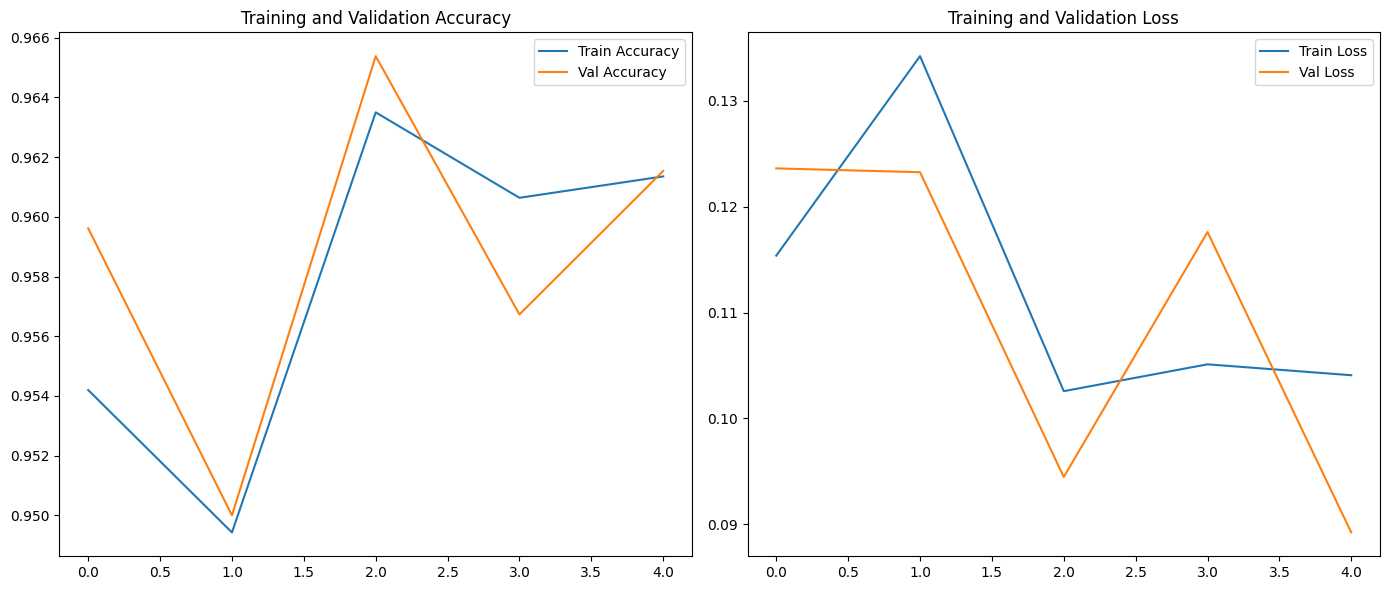

In [75]:
# 📈 Plot training curves
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training(history_resnet)

In [76]:
# 📊 Model predictions and evaluation
y_pred_probs = model_resnet.predict(test_rgb, steps=len(test), verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test.classes
class_names = list(test.class_indices.keys())

39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step


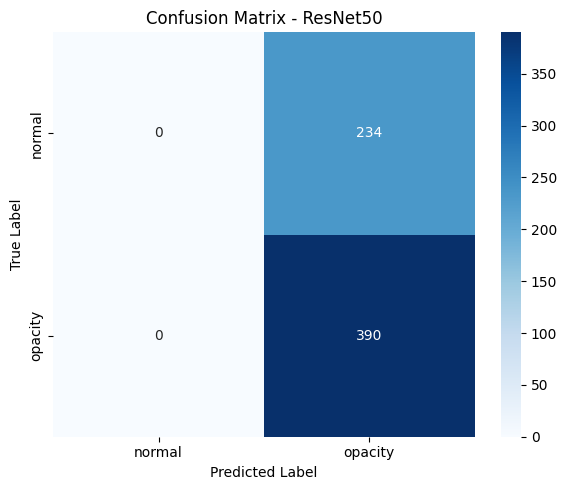

In [79]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - ResNet50')
plt.tight_layout()
plt.show()

In [80]:
# Classification Report
report_text = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report_text)

Classification Report:

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       234
     opacity       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
# Convert classification report to DataFrame
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_classification = pd.DataFrame(report_dict).transpose()
print("\nClassification Report (DataFrame):")
df_classification


 Classification Report (DataFrame):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  recall  f1-score  support
normal         0.000000   0.000  0.000000  234.000
opacity        0.625000   1.000  0.769231  390.000
accuracy       0.625000   0.625  0.625000    0.625
macro avg      0.312500   0.500  0.384615  624.000
weighted avg   0.390625   0.625  0.480769  624.000

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


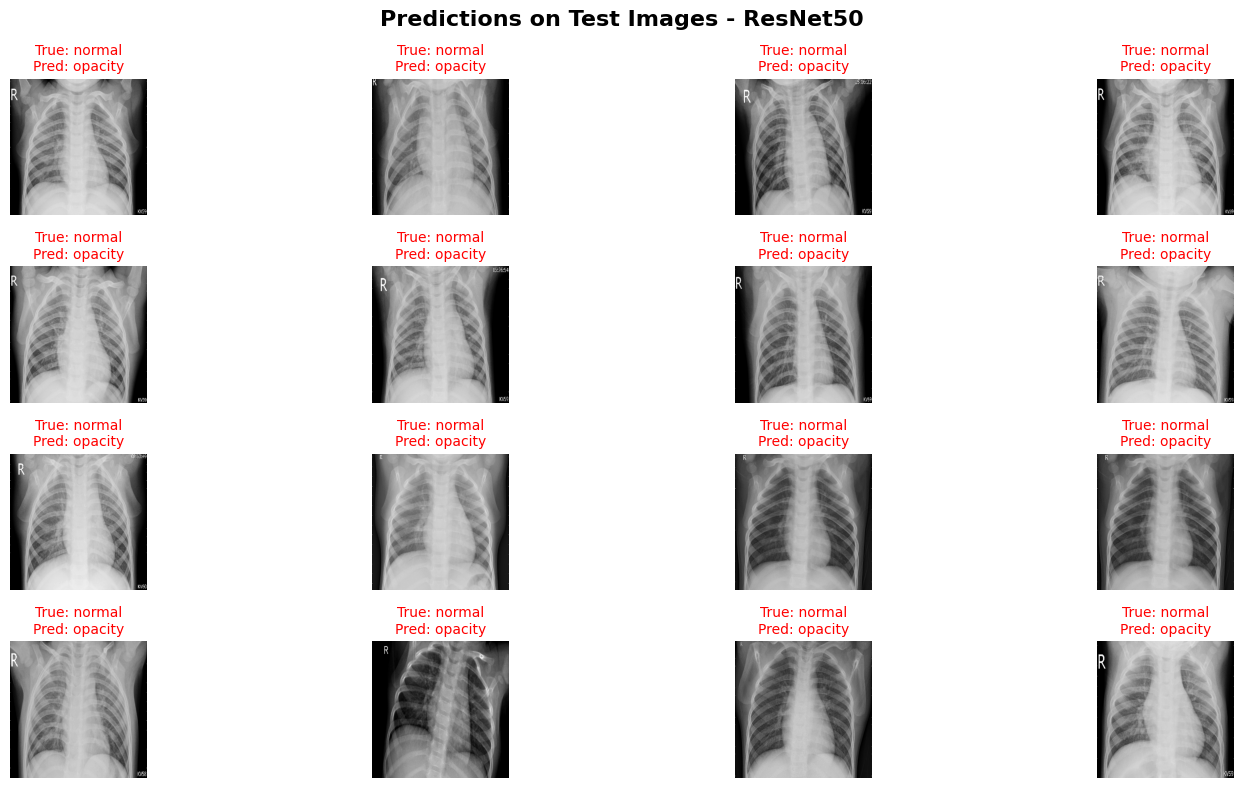

In [82]:
# 🖼️ Visualize predictions on a test batch
x_batch, y_batch = next(test)
x_batch_rgb = np.repeat(x_batch, 3, axis=-1)

# predictions for batch
y_pred_probs_batch = model_resnet.predict(x_batch_rgb)
y_pred_labels = (y_pred_probs_batch > 0.5).astype(int).flatten()

plt.figure(figsize=(16, 8))
for i in range(len(x_batch)):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_batch[i].squeeze(), cmap='gray')
    plt.axis('off')
    true_lbl = class_names[int(y_batch[i])]
    pred_lbl = class_names[int(y_pred_labels[i])]
    color = 'green' if true_lbl == pred_lbl else 'red'
    plt.title(f"True: {true_lbl}\nPred: {pred_lbl}", color=color, fontsize=10)

plt.suptitle("Predictions on Test Images - ResNet50", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [83]:
# 📈 Compute overall performance metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

# save as DataFrame
df_metrics_resnet = pd.DataFrame([{
    'Model': 'ResNet50',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1 Score': f1
}])

df_metrics_resnet

Model  Accuracy  Precision  Recall  F1 Score
0  ResNet50     0.625      0.625     1.0  0.769231